## some preparation: 
create a Python version of the NPZF model

In [1]:
#%matplotlib notebook
import numpy as np

Specify parameters

In [2]:
# specify parameter values, these are used as reference parameters to generate synthetic data
theta = {
    'vmax':0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat':0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz':0.02,        # zooplankton grazing rate
    'mort_p':0.02,      # phytoplankton mortality rate
    'mort_z':0.03,      # zooplankton mortality rate
    'irr':0.8,          # light amplitude
    'beta':0.04,
    'mort_f':0.1
}

Define ODE function

In [3]:
# specify model 
def npzf(x,t,theta):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    theta: model parameters
    '''
    n = max(x[0], 0.0)
    p = max(x[1], 0.0)
    z = max(x[2], 0.0)
    f = max(x[3], 0.0)
    
    light   = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])
    growth  = theta['vmax']*n/(theta['nuthalfsat']+n) * light * p
    grazing = theta['graz'] * p*z
    ploss   = theta['mort_p'] * p
    zloss   = theta['mort_z'] * z*z
    fgrowth = theta['beta']*z
    floss   = theta['mort_f']*f
    return np.array((-growth+ploss+zloss,
                     growth-grazing-ploss,
                     grazing-zloss,
                     fgrowth-floss))

run the model using an ODE solver

In [4]:
from scipy.integrate import odeint

# initial conditions
x0 = np.array((0.6,0.15,0.25,0.1))

# initialize time vector
t = np.arange(0.0,2*365.0,1.0)

x = odeint(npzf, x0, t, args=(theta,))

plot the model output

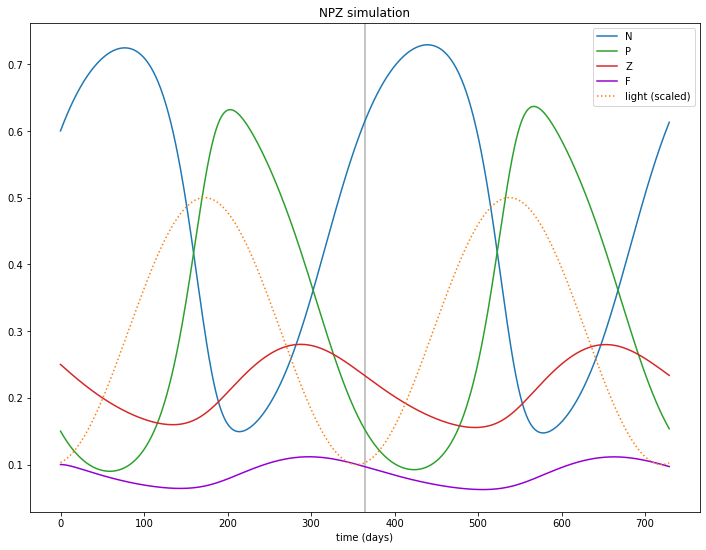

In [6]:
colors = ('#1f77b4','#2ca02c','#d62728','darkviolet') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z','F')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ simulation', xlabel='time (days)')
ax.legend()
None

sample from one of the parameters randomly and plot the resulting output 

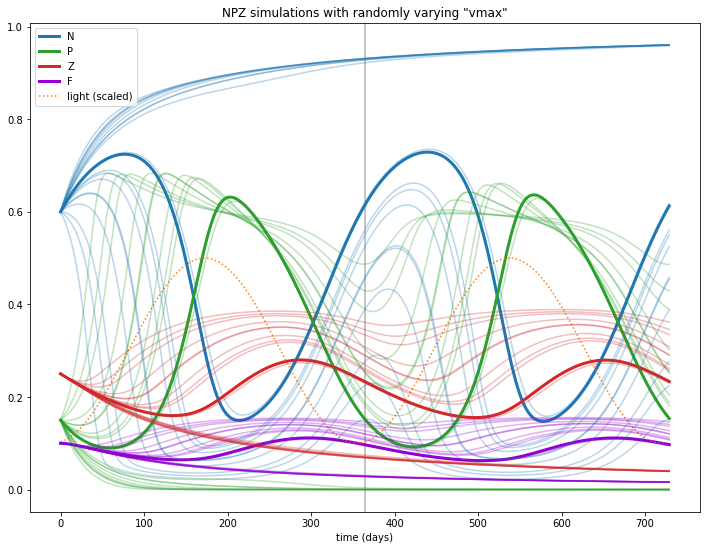

In [7]:
fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z','F')):
    ax.plot(t,x[:,i], color=colors[i], linewidth=3, label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')

theta_rand = theta.copy()
for isample in range(20):
    theta_rand['vmax'] = np.random.normal(loc=0.1, scale=0.1)
    x_rand = odeint(npzf, x0, t, args=(theta_rand,))
    for i,name in enumerate(('N','P','Z','F')):
        ax.plot(t,x_rand[:,i], color=colors[i], alpha=0.3)
ax.set(title='NPZ simulations with randomly varying "vmax"', xlabel='time (days)')
ax.legend()
None

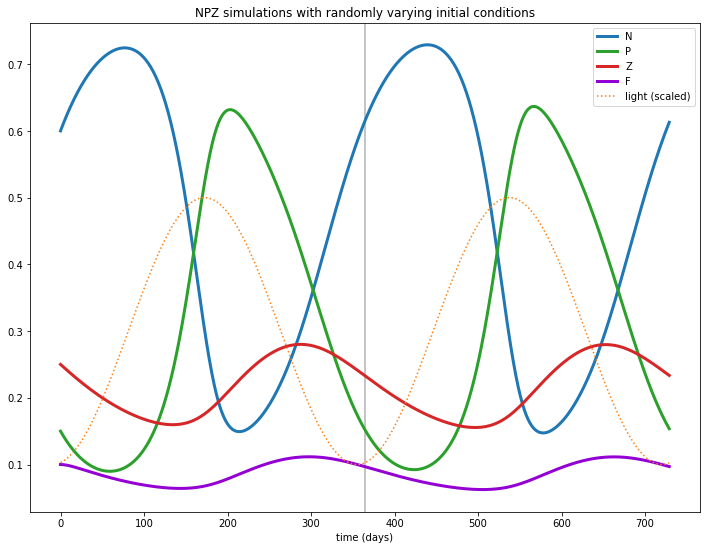

In [8]:
fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z','F')):
    ax.plot(t,x[:,i], color=colors[i], linewidth=3, label=name)
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ simulations with randomly varying initial conditions', xlabel='time (days)')
ax.legend()

generate synthetic observations and save them to file

In [9]:
sigma = np.array([0.03,0.03,0.03,0.03])

iobs = np.random.choice(len(t)//10-1, 20, replace=False)*10 + 1 # do not allow zeros
iobs.sort()

tobs = t[iobs]
obs = np.maximum(0.0, x[iobs,:] + np.random.normal(size=(iobs.size,4))*sigma)

# write obs to file
np.savetxt('../data/data_npz_synthetic_fish.csv', np.concatenate((tobs[:,None],obs),    axis=1), delimiter=',', header='time,N,P,Z')

plot data with observations

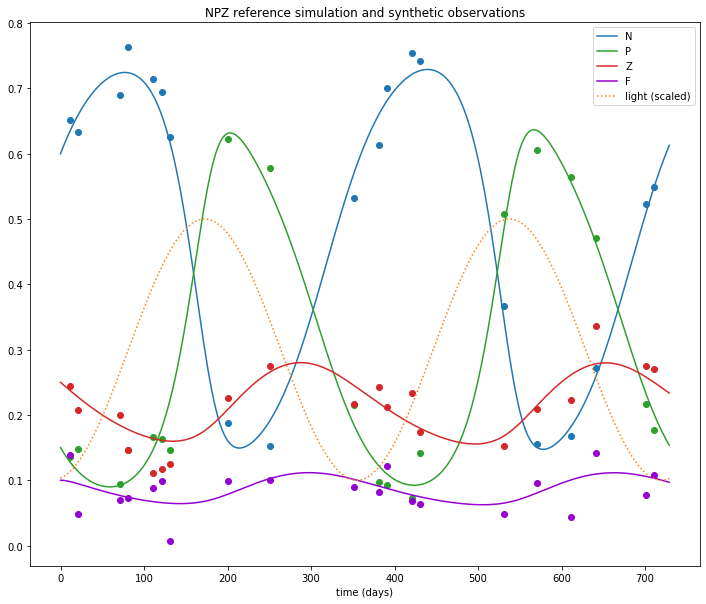

In [11]:
colors = ('#1f77b4','#2ca02c','#d62728','darkviolet') # colors for N, P, Z

light = 1.0 + 0.5*(theta['irr']*np.sin(np.pi*((t-81.25)/182.5)) - theta['irr'])

import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,10))
for i,name in enumerate(('N','P','Z','F')):
    ax.plot(t,x[:,i], color=colors[i], label=name)
    ax.plot(tobs, obs[:,i], color=colors[i], marker='o', ls='none')
ax.plot(t,0.5*light,linestyle=':',color='#ff7f0e',label='light (scaled)')
ax.set(title='NPZ reference simulation and synthetic observations', xlabel='time (days)')
ax.legend()
None